In [1]:
!pip install --quiet transformers datasets rouge-score evaluate rank_bm25 sentence-transformers scikit-learn

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

print(" All packages installed successfully!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


 All packages installed successfully!


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering,
    TrainingArguments, Trainer, pipeline,
    EarlyStoppingCallback, TrainerCallback
)
import pandas as pd
import numpy as np
from datasets import Dataset as HFDataset
import json
import re
import warnings
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging
from sklearn.model_selection import train_test_split
import os
import gc
from collections import defaultdict
import collections

# Evaluation metrics
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score, f1_score
import evaluate

# Context retrieval
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Logging setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(" All imports successful!")


🖥️  Using device: cuda
 All imports successful!


In [3]:
class AnswerSpanHandler:
    """Ensures answers are properly located within contexts"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def find_answer_in_context(self, answer: str, context: str) -> Tuple[int, int]:
        """
        Find the answer in context and return start/end positions.
        Returns (-1, -1) if answer not found.
        """
        # Clean whitespace
        answer_clean = ' '.join(answer.split()).strip()
        context_clean = ' '.join(context.split()).strip()

        # Try exact match (case-insensitive)
        answer_lower = answer_clean.lower()
        context_lower = context_clean.lower()

        start_idx = context_lower.find(answer_lower)

        if start_idx != -1:
            end_idx = start_idx + len(answer_clean)
            return (start_idx, end_idx)

        # Try partial matching - find best substring match
        answer_words = answer_lower.split()
        best_match = (-1, -1)
        best_score = 0

        # Sliding window to find best match
        for i in range(len(context_lower)):
            matched_words = 0
            j = i
            for word in answer_words:
                if j >= len(context_lower):
                    break
                if context_lower[j:].startswith(word):
                    matched_words += 1
                    j += len(word) + 1

            score = matched_words / len(answer_words)
            if score > best_score and score >= 0.5:  # At least 50% match
                best_score = score
                best_match = (i, j)

        if best_match[0] != -1:
            return best_match

        return (-1, -1)

    def fix_dataset_answer_spans(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fix all answer spans in the dataset"""
        print("🔧 Fixing answer spans in dataset...")

        fixed_rows = []
        fixed_contexts = 0
        valid_spans = 0

        for idx, row in df.iterrows():
            question = str(row['question']).strip()
            context = str(row['context']).strip()
            answer = str(row['answer']).strip()

            # Skip empty entries
            if not question or not context or not answer:
                continue

            # Find correct answer position
            start_pos, end_pos = self.find_answer_in_context(answer, context)

            if start_pos == -1:
                # Answer not in context - fix by appending
                fixed_context = f"{context} {answer}"
                start_pos = len(context) + 1
                end_pos = start_pos + len(answer)
                fixed_contexts += 1
            else:
                fixed_context = context
                valid_spans += 1

            fixed_row = row.copy()
            fixed_row['context'] = fixed_context
            fixed_row['answer_start'] = start_pos
            fixed_row['answer_end'] = end_pos
            fixed_rows.append(fixed_row)

        print(f" Fixed {fixed_contexts} contexts (answer not found)")
        print(f" Validated {valid_spans} contexts (answer found)")
        print(f" Total: {len(fixed_rows)} examples ready")

        return pd.DataFrame(fixed_rows)

    def validate_answer_span(self, context: str, answer: str,
                            start_pos: int, end_pos: int) -> bool:
        """Validate that answer span is correct"""
        extracted = context[start_pos:end_pos].strip()
        answer_clean = answer.strip()
        return extracted.lower() == answer_clean.lower()

print(" AnswerSpanHandler class defined!")

 AnswerSpanHandler class defined!


In [4]:
class RwandaTourismDatasetCreator:
    """Create experimental datasets with proper span handling"""

    def __init__(self, data_path: str):
        self.data_path = data_path
        self.df = pd.read_csv(data_path)
        self.span_handler = AnswerSpanHandler()

        print(f" Loaded {len(self.df)} Q&A pairs from {data_path}")

        # Ensure required columns
        if 'answer_start' not in self.df.columns:
            self.df['answer_start'] = 0
        if 'answer_end' not in self.df.columns:
            self.df['answer_end'] = self.df['answer'].str.len()
        if 'id' not in self.df.columns:
            self.df['id'] = range(len(self.df))

    def create_experimental_datasets(self):
        """Create three experimental datasets"""

        print("\n" + "="*70)
        print(" CREATING EXPERIMENTAL DATASETS")
        print("="*70)

        # Conservative: Original data with minimal processing
        conservative_df = self.df.copy()
        conservative_df['experiment_type'] = 'conservative'
        conservative_df = self.span_handler.fix_dataset_answer_spans(conservative_df)

        # Balanced: Moderate augmentation
        balanced_df = self._create_balanced_dataset()
        balanced_df['experiment_type'] = 'balanced'
        balanced_df = self.span_handler.fix_dataset_answer_spans(balanced_df)

        # Aggressive: Heavy augmentation
        aggressive_df = self._create_aggressive_dataset()
        aggressive_df['experiment_type'] = 'aggressive'
        aggressive_df = self.span_handler.fix_dataset_answer_spans(aggressive_df)

        print(f"\n Dataset Summary:")
        print(f"   Conservative: {len(conservative_df)} examples")
        print(f"   Balanced: {len(balanced_df)} examples")
        print(f"   Aggressive: {len(aggressive_df)} examples")

        return {
            'conservative': conservative_df,
            'balanced': balanced_df,
            'aggressive': aggressive_df
        }

    def _create_balanced_dataset(self):
        """Create balanced dataset with moderate augmentation"""
        df = self.df.copy()
        augmented_rows = []

        for idx, row in df.iterrows():
            question_lower = row['question'].lower()

            # Add 1-2 variations per question
            if 'how many' in question_lower:
                new_row = row.copy()
                new_row['question'] = row['question'].replace('How many', 'What is the number of')
                new_row['id'] = f"{row['id']}_balanced_var1"
                augmented_rows.append(new_row)

            if 'what' in question_lower and len(question_lower.split()) > 3:
                new_row = row.copy()
                new_row['question'] = row['question'].replace('What', 'Tell me about')
                new_row['id'] = f"{row['id']}_balanced_var2"
                augmented_rows.append(new_row)

        if augmented_rows:
            augmented_df = pd.DataFrame(augmented_rows)
            df = pd.concat([df, augmented_df], ignore_index=True)

        return df

    def _create_aggressive_dataset(self):
        """Create aggressive dataset with heavy augmentation"""
        df = self.df.copy()
        augmented_rows = []

        for idx, row in df.iterrows():
            question_lower = row['question'].lower()
            variations = []

            # Multiple question variations
            if 'how many' in question_lower:
                variations.extend([
                    row['question'].replace('How many', 'What is the number of'),
                    row['question'].replace('How many', 'Tell me how many'),
                    row['question'].replace('How many', 'Can you tell me how many')
                ])

            if 'what' in question_lower:
                variations.extend([
                    row['question'].replace('What', 'Tell me about'),
                    row['question'].replace('What', 'Can you describe'),
                    row['question'].replace('What are', 'Which are')
                ])

            if 'where' in question_lower:
                variations.extend([
                    row['question'].replace('Where', 'In which location'),
                    row['question'].replace('Where', 'At what place')
                ])

            # Add variations
            for i, var_question in enumerate(variations):
                if var_question != row['question']:
                    new_row = row.copy()
                    new_row['question'] = var_question
                    new_row['id'] = f"{row['id']}_aggressive_var_{i}"
                    augmented_rows.append(new_row)

        if augmented_rows:
            augmented_df = pd.DataFrame(augmented_rows)
            df = pd.concat([df, augmented_df], ignore_index=True)

        return df

print(" RwandaTourismDatasetCreator class defined!")

 RwandaTourismDatasetCreator class defined!


In [5]:
class ImprovedQuestionAnsweringTrainer:
    """Enhanced trainer with proper answer span handling"""

    def __init__(self, model_name: str = "distilbert-base-cased-distilled-squad"):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print(f" Initialized trainer with model: {model_name}")

    def prepare_datasets(self, df: pd.DataFrame):
        """Prepare datasets with validation"""

        # Validate sample
        print("\n Validating sample entries:")
        span_handler = AnswerSpanHandler()
        for idx in range(min(3, len(df))):
            row = df.iloc[idx]
            is_valid = span_handler.validate_answer_span(
                row['context'], row['answer'],
                row['answer_start'], row['answer_end']
            )
            status = '✅' if is_valid else '❌'
            print(f"  Example {idx + 1}: {status}")
            if not is_valid:
                print(f"    Expected: {row['answer']}")
                print(f"    Got: {row['context'][row['answer_start']:row['answer_end']]}")

        # Split data
        train_df, eval_df = train_test_split(
            df, test_size=0.2, random_state=42,
            stratify=df['category']
        )

        print(f"\n Dataset split:")
        print(f"   Train: {len(train_df)} examples")
        print(f"   Eval: {len(eval_df)} examples")

        # Create HuggingFace datasets
        train_dataset = HFDataset.from_pandas(train_df)
        eval_dataset = HFDataset.from_pandas(eval_df)

        # Tokenize
        train_dataset = train_dataset.map(
            self._tokenize_function,
            batched=True,
            remove_columns=train_dataset.column_names
        )

        eval_dataset = eval_dataset.map(
            self._tokenize_function,
            batched=True,
            remove_columns=eval_dataset.column_names
        )

        return train_dataset, eval_dataset, train_df, eval_df

    def _tokenize_function(self, examples):
        """FIXED tokenization with proper span mapping"""

        # Tokenize with offsets
        tokenized = self.tokenizer(
            examples['question'],
            examples['context'],
            truncation="only_second",
            padding="max_length",
            max_length=384,
            return_offsets_mapping=True,
            return_tensors=None
        )

        start_positions = []
        end_positions = []

        for i in range(len(examples['question'])):
            # Character-level positions
            answer_start_char = examples['answer_start'][i]
            answer_end_char = examples['answer_end'][i]

            offsets = tokenized['offset_mapping'][i]
            sequence_ids = tokenized.sequence_ids(i)

            # Find context start
            context_start = 0
            for idx, seq_id in enumerate(sequence_ids):
                if seq_id == 1:
                    context_start = idx
                    break

            # Find token positions
            start_token = 0
            end_token = 0

            for idx in range(context_start, len(offsets)):
                if offsets[idx] == (0, 0):
                    continue

                token_start, token_end = offsets[idx]

                # Token contains answer start
                if token_start <= answer_start_char < token_end:
                    start_token = idx

                # Token contains answer end
                if token_start < answer_end_char <= token_end:
                    end_token = idx
                    break

            # Ensure valid positions
            if end_token < start_token or start_token == 0:
                start_token = 0
                end_token = 0

            start_positions.append(start_token)
            end_positions.append(end_token)

        tokenized['start_positions'] = start_positions
        tokenized['end_positions'] = end_positions

        del tokenized['offset_mapping']

        return tokenized

print(" ImprovedQuestionAnsweringTrainer class defined!")

 ImprovedQuestionAnsweringTrainer class defined!


In [6]:
class ContextRetrievalSystem:
    """Hybrid BM25 + Semantic search for context retrieval"""

    def __init__(self, retrieval_method: str = "hybrid"):
        self.retrieval_method = retrieval_method
        self.bm25 = None
        self.sentence_model = None
        self.context_embeddings = None
        self.contexts = []
        self.stop_words = set(stopwords.words('english'))

    def build_retrieval_index(self, contexts: List[str]):
        """Build retrieval index"""
        self.contexts = contexts

        if self.retrieval_method in ["bm25", "hybrid"]:
            tokenized = [self._tokenize_text(ctx) for ctx in contexts]
            self.bm25 = BM25Okapi(tokenized)
            print(f" Built BM25 index: {len(contexts)} contexts")

        if self.retrieval_method in ["semantic", "hybrid"]:
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
            self.context_embeddings = self.sentence_model.encode(
                contexts, convert_to_tensor=True, show_progress_bar=True
            )
            print(f" Built semantic index: {len(contexts)} contexts")

    def _tokenize_text(self, text: str) -> List[str]:
        """Tokenize and clean text"""
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words and len(t) > 2]
        return tokens

    def retrieve_contexts(self, query: str, top_k: int = 3) -> List[str]:
        """Retrieve top-k contexts"""
        if self.retrieval_method == "bm25":
            return self._bm25_retrieval(query, top_k)
        elif self.retrieval_method == "semantic":
            return self._semantic_retrieval(query, top_k)
        else:
            return self._hybrid_retrieval(query, top_k)

    def _bm25_retrieval(self, query: str, top_k: int) -> List[str]:
        """BM25 retrieval"""
        tokenized_query = self._tokenize_text(query)
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [self.contexts[i] for i in top_indices if scores[i] > 0]

    def _semantic_retrieval(self, query: str, top_k: int) -> List[str]:
        """Semantic retrieval"""
        query_embedding = self.sentence_model.encode(query, convert_to_tensor=True)
        cos_scores = util.cos_sim(query_embedding, self.context_embeddings)[0]
        top_results = torch.topk(cos_scores, k=min(top_k, len(self.contexts)))
        return [self.contexts[idx] for idx in top_results.indices]

    def _hybrid_retrieval(self, query: str, top_k: int) -> List[str]:
        """Hybrid retrieval"""
        bm25_results = self._bm25_retrieval(query, top_k * 2)
        semantic_results = self._semantic_retrieval(query, top_k * 2)

        # Combine with scoring
        combined = {}
        for ctx in bm25_results:
            combined[ctx] = combined.get(ctx, 0) + 1
        for ctx in semantic_results:
            combined[ctx] = combined.get(ctx, 0) + 1

        sorted_results = sorted(combined.items(), key=lambda x: x[1], reverse=True)
        return [ctx for ctx, _ in sorted_results[:top_k]]

print(" ContextRetrievalSystem class defined!")


 ContextRetrievalSystem class defined!


In [7]:
class ComprehensiveEvaluator:
    """Comprehensive evaluation with multiple metrics"""

    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True
        )

    def evaluate_experiment(self, model_path: str, test_df: pd.DataFrame,
                          experiment_name: str):
        """Evaluate a single experiment"""

        print(f"\n{'='*70}")
        print(f"🔬 EVALUATING {experiment_name.upper()} EXPERIMENT")
        print(f"{'='*70}")

        # Load model
        model = AutoModelForQuestionAnswering.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        qa_pipeline = pipeline(
            "question-answering",
            model=model,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1
        )

        results = {
            'exact_matches': [],
            'f1_scores': [],
            'rouge_scores': {'rouge1': [], 'rouge2': [], 'rougeL': []},
            'predictions': [],
            'confidences': []
        }

        for idx, row in tqdm(test_df.iterrows(), total=len(test_df),
                            desc=f"Testing {experiment_name}"):
            try:
                result = qa_pipeline(
                    question=row['question'],
                    context=row['context'],
                    max_answer_len=200,
                    handle_impossible_answer=False
                )

                pred = result['answer'].strip()
                true = row['answer'].strip()

                # Exact match
                em = pred.lower() == true.lower()
                results['exact_matches'].append(em)

                # F1 score
                f1 = self._compute_f1(pred.lower(), true.lower())
                results['f1_scores'].append(f1)

                # ROUGE scores
                rouge = self.rouge_scorer.score(true, pred)
                for key in results['rouge_scores']:
                    results['rouge_scores'][key].append(rouge[key].fmeasure)

                results['predictions'].append(pred)
                results['confidences'].append(result['score'])

            except Exception as e:
                print(f" Error on row {idx}: {e}")
                continue

        # Compute averages
        metrics = {
            'exact_match': np.mean(results['exact_matches']),
            'f1': np.mean(results['f1_scores']),
            'rouge1': np.mean(results['rouge_scores']['rouge1']),
            'rouge2': np.mean(results['rouge_scores']['rouge2']),
            'rougeL': np.mean(results['rouge_scores']['rougeL']),
            'avg_confidence': np.mean(results['confidences']),
            'total_questions': len(test_df)
        }

        print(f"\n {experiment_name.upper()} RESULTS:")
        print(f"   Exact Match: {metrics['exact_match']:.3f}")
        print(f"   F1 Score: {metrics['f1']:.3f}")
        print(f"   ROUGE-1: {metrics['rouge1']:.3f}")
        print(f"   ROUGE-2: {metrics['rouge2']:.3f}")
        print(f"   ROUGE-L: {metrics['rougeL']:.3f}")
        print(f"   Avg Confidence: {metrics['avg_confidence']:.3f}")

        return metrics, results

    def _compute_f1(self, pred_text: str, true_text: str) -> float:
        """Compute token-level F1 score"""
        pred_tokens = pred_text.split()
        true_tokens = true_text.split()

        if not pred_tokens or not true_tokens:
            return 0.0

        common = collections.Counter(pred_tokens) & collections.Counter(true_tokens)
        num_same = sum(common.values())

        if num_same == 0:
            return 0.0

        precision = num_same / len(pred_tokens)
        recall = num_same / len(true_tokens)
        f1 = (2 * precision * recall) / (precision + recall)

        return f1

    def plot_comparison(self, all_metrics: Dict):
        """Plot comprehensive comparison"""

        experiments = list(all_metrics.keys())
        metrics_to_plot = ['exact_match', 'f1', 'rouge1', 'rouge2', 'rougeL']

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

        for idx, metric in enumerate(metrics_to_plot):
            values = [all_metrics[exp][metric] for exp in experiments]
            bars = axes[idx].bar(experiments, values, color=colors, alpha=0.8)
            axes[idx].set_title(f'{metric.upper()}', fontsize=14, fontweight='bold')
            axes[idx].set_ylabel('Score', fontsize=12)
            axes[idx].set_ylim(0, 1)
            axes[idx].grid(axis='y', alpha=0.3)

            # Add value labels
            for bar, v in zip(bars, values):
                axes[idx].text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.01,
                    f'{v:.3f}',
                    ha='center',
                    va='bottom',
                    fontweight='bold'
                )

        # Hide last subplot
        axes[-1].axis('off')

        plt.suptitle('🏆 Rwanda Tourism QA - Experiment Comparison',
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

print(" ComprehensiveEvaluator class defined!")

 ComprehensiveEvaluator class defined!


In [8]:
class NonTourismQuestionHandler:
    """Handle questions not related to Rwanda tourism"""

    def __init__(self):
        self.tourism_keywords = {
            'national_parks': [
                'park', 'gorilla', 'chimpanzee', 'wildlife', 'safari',
                'akagera', 'volcanoes', 'nyungwe', 'gishwati', 'mukura',
                'trekking', 'hiking', 'animals', 'birds'
            ],
            'cultural_heritage': [
                'museum', 'culture', 'dance', 'traditional', 'heritage',
                'palace', 'history', 'intore', 'art', 'monument',
                'ethnographic', 'genocide', 'memorial'
            ],
            'general_tourism': [
                'rwanda', 'visit', 'tourism', 'travel', 'tourist',
                'attraction', 'destination', 'kigali'
            ]
        }

    def is_tourism_related(self, question: str) -> Tuple[bool, str]:
        """Check if question is tourism-related"""
        question_lower = question.lower()

        # Check each category
        for category, keywords in self.tourism_keywords.items():
            if any(keyword in question_lower for keyword in keywords):
                return True, category

        return False, "non_tourism"

    def get_fallback_response(self, question: str) -> str:
        """Generate fallback response for non-tourism questions"""
        return (
            "I apologize, but I'm specifically designed to answer questions "
            "about Rwanda's tourism, including national parks and cultural heritage. "
            "Your question doesn't seem to be related to these topics. "
            "Please ask me about Rwanda's national parks (Volcanoes, Akagera, "
            "Nyungwe, Gishwati-Mukura) or cultural heritage sites (museums, "
            "traditional dances, monuments, etc.)."
        )

print(" NonTourismQuestionHandler class defined!")

 NonTourismQuestionHandler class defined!


In [10]:
print("\n" + "="*70)
print(" CREATING EXPERIMENTAL DATASETS")
print("="*70)

# Create dataset creator
creator = RwandaTourismDatasetCreator('visitRwanda_qa.csv')
experimental_datasets = creator.create_experimental_datasets()

# Save datasets
for exp_name, df in experimental_datasets.items():
    filename = f'rwanda_tourism_{exp_name}_FIXED.csv'
    df.to_csv(filename, index=False)
    print(f" Saved: {filename}")

print("\n Dataset creation completed!")



 CREATING EXPERIMENTAL DATASETS
 Loaded 236 Q&A pairs from visitRwanda_qa.csv

 CREATING EXPERIMENTAL DATASETS
🔧 Fixing answer spans in dataset...
 Fixed 0 contexts (answer not found)
 Validated 236 contexts (answer found)
 Total: 236 examples ready
🔧 Fixing answer spans in dataset...
 Fixed 0 contexts (answer not found)
 Validated 351 contexts (answer found)
 Total: 351 examples ready
🔧 Fixing answer spans in dataset...
 Fixed 0 contexts (answer not found)
 Validated 506 contexts (answer found)
 Total: 506 examples ready

 Dataset Summary:
   Conservative: 236 examples
   Balanced: 351 examples
   Aggressive: 506 examples
 Saved: rwanda_tourism_conservative_FIXED.csv
 Saved: rwanda_tourism_balanced_FIXED.csv
 Saved: rwanda_tourism_aggressive_FIXED.csv

 Dataset creation completed!


In [12]:
print("\n" + "="*70)
print(" TRAINING CONSERVATIVE EXPERIMENT")
print("="*70)

# Initialize trainer
trainer_cons = ImprovedQuestionAnsweringTrainer("distilbert-base-cased-distilled-squad")

# Prepare datasets
conservative_df = experimental_datasets['conservative']
train_dataset_cons, eval_dataset_cons, train_df_cons, eval_df_cons = \
    trainer_cons.prepare_datasets(conservative_df)

# Training configuration
training_args_cons = TrainingArguments(
    output_dir='./models/conservative_FIXED',
    num_train_epochs=8,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=10,
    eval_steps=50,
    save_steps=100,
    eval_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    logging_dir='./logs/conservative_fixed',
    report_to=None,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=False,
)

# Initialize model
model_cons = AutoModelForQuestionAnswering.from_pretrained(trainer_cons.model_name)

# Create trainer
trainer_obj_cons = Trainer(
    model=model_cons,
    args=training_args_cons,
    train_dataset=train_dataset_cons,
    eval_dataset=eval_dataset_cons,
    tokenizer=trainer_cons.tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Train
print("🎯 Starting training...")
trainer_obj_cons.train()

# Save
trainer_obj_cons.save_model('./models/conservative_FIXED')
trainer_cons.tokenizer.save_pretrained('./models/conservative_FIXED')

# Evaluate
eval_results_cons = trainer_obj_cons.evaluate()
print("\n📊 CONSERVATIVE RESULTS:")
for key, value in eval_results_cons.items():
    print(f"   {key}: {value:.4f}")

print(" Conservative experiment completed!")

# Cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()


 TRAINING CONSERVATIVE EXPERIMENT
 Initialized trainer with model: distilbert-base-cased-distilled-squad

 Validating sample entries:
  Example 1: ✅
  Example 2: ✅
  Example 3: ✅

 Dataset split:
   Train: 188 examples
   Eval: 48 examples


Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

🎯 Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: p-imanzi (p-imanzi-african-leadership-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
50,0.022100,0.036011
100,0.000300,0.001533
150,0.000100,0.000804
200,0.000100,0.000672
250,0.000000,0.000633
300,0.000000,0.000601
350,0.000000,0.000607



📊 CONSERVATIVE RESULTS:
   eval_loss: 0.0006
   eval_runtime: 0.5672
   eval_samples_per_second: 84.6310
   eval_steps_per_second: 21.1580
   epoch: 8.0000
 Conservative experiment completed!


In [15]:
print("\n" + "="*70)
print(" TRAINING BALANCED EXPERIMENT")
print("="*70)

# Initialize trainer
trainer_bal = ImprovedQuestionAnsweringTrainer("distilbert-base-cased-distilled-squad")

# Prepare datasets
balanced_df = experimental_datasets['balanced']
# Drop or reset the id column
if 'id' in balanced_df.columns:
    balanced_df = balanced_df.drop(columns=['id'])

#Add clean numeric IDs again
balanced_df['id'] = range(len(balanced_df))
train_dataset_bal, eval_dataset_bal, train_df_bal, eval_df_bal = \
    trainer_bal.prepare_datasets(balanced_df)

# Training configuration
training_args_bal = TrainingArguments(
    output_dir='./models/balanced_FIXED',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=10,
    eval_steps=50,
    save_steps=100,
    eval_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    logging_dir='./logs/balanced_fixed',
    report_to=None,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=False,
)

# Initialize model
model_bal = AutoModelForQuestionAnswering.from_pretrained(trainer_bal.model_name)

# Create trainer
trainer_obj_bal = Trainer(
    model=model_bal,
    args=training_args_bal,
    train_dataset=train_dataset_bal,
    eval_dataset=eval_dataset_bal,
    tokenizer=trainer_bal.tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Train
print(" Starting training...")
trainer_obj_bal.train()

# Save
trainer_obj_bal.save_model('./models/balanced_FIXED')
trainer_bal.tokenizer.save_pretrained('./models/balanced_FIXED')

# Evaluate
eval_results_bal = trainer_obj_bal.evaluate()
print("\n BALANCED RESULTS:")
for key, value in eval_results_bal.items():
    print(f"   {key}: {value:.4f}")

print(" Balanced experiment completed!")

# Cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()


 TRAINING BALANCED EXPERIMENT
 Initialized trainer with model: distilbert-base-cased-distilled-squad

 Validating sample entries:
  Example 1: ✅
  Example 2: ✅
  Example 3: ✅

 Dataset split:
   Train: 280 examples
   Eval: 71 examples


Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

 Starting training...


Step,Training Loss,Validation Loss
50,0.129100,0.012818
100,0.000100,0.000071
150,0.000000,0.000032
200,0.000000,0.000019
250,0.000000,0.000017
300,0.000000,0.000015
350,0.000000,0.000015
400,0.000000,0.000017
450,0.000000,0.000014
500,0.000000,0.000013



 BALANCED RESULTS:
   eval_loss: 0.0000
   eval_runtime: 0.8102
   eval_samples_per_second: 87.6300
   eval_steps_per_second: 22.2160
   epoch: 10.0000
 Balanced experiment completed!


In [17]:
print("\n" + "="*70)
print("🚀 TRAINING AGGRESSIVE EXPERIMENT")
print("="*70)

# Initialize trainer
trainer_agg = ImprovedQuestionAnsweringTrainer("distilbert-base-cased-distilled-squad")

# Prepare datasets
aggressive_df = experimental_datasets['aggressive']
# Drop or reset the id column
if 'id' in aggressive_df.columns:
    aggressive_df = aggressive_df.drop(columns=['id'])

#Add clean numeric IDs again
aggressive_df['id'] = range(len(aggressive_df))
train_dataset_agg, eval_dataset_agg, train_df_agg, eval_df_agg = \
    trainer_agg.prepare_datasets(aggressive_df)

# Training configuration
training_args_agg = TrainingArguments(
    output_dir='./models/aggressive_FIXED',
    num_train_epochs=12,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.005,
    warmup_ratio=0.05,
    logging_steps=10,
    eval_steps=50,
    save_steps=100,
    eval_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    logging_dir='./logs/aggressive_fixed',
    report_to=None,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=False,
)

# Initialize model
model_agg = AutoModelForQuestionAnswering.from_pretrained(trainer_agg.model_name)

# Create trainer
trainer_obj_agg = Trainer(
    model=model_agg,
    args=training_args_agg,
    train_dataset=train_dataset_agg,
    eval_dataset=eval_dataset_agg,
    tokenizer=trainer_agg.tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Train
print("🎯 Starting training...")
trainer_obj_agg.train()

# Save
trainer_obj_agg.save_model('./models/aggressive_FIXED')
trainer_agg.tokenizer.save_pretrained('./models/aggressive_FIXED')

# Evaluate
eval_results_agg = trainer_obj_agg.evaluate()
print("\n📊 AGGRESSIVE RESULTS:")
for key, value in eval_results_agg.items():
    print(f"   {key}: {value:.4f}")

print(" Aggressive experiment completed!")

# Cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()


🚀 TRAINING AGGRESSIVE EXPERIMENT
 Initialized trainer with model: distilbert-base-cased-distilled-squad

 Validating sample entries:
  Example 1: ✅
  Example 2: ✅
  Example 3: ✅

 Dataset split:
   Train: 404 examples
   Eval: 102 examples


Map:   0%|          | 0/404 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

🎯 Starting training...


Step,Training Loss,Validation Loss
50,0.001700,0.010487
100,0.019400,0.000016
150,0.000000,0.000007
200,0.000000,0.000003
250,0.000000,0.000003
300,0.000000,0.000002
350,0.000000,0.000002
400,0.000000,0.000002
450,0.000000,0.000002
500,0.000000,0.000002



📊 AGGRESSIVE RESULTS:
   eval_loss: 0.0000
   eval_runtime: 1.2044
   eval_samples_per_second: 84.6870
   eval_steps_per_second: 21.5870
   epoch: 7.9208
 Aggressive experiment completed!



 COMPREHENSIVE EVALUATION OF ALL EXPERIMENTS

🔬 EVALUATING CONSERVATIVE EXPERIMENT


Device set to use cuda:0
Testing conservative: 100%|██████████| 48/48 [00:01<00:00, 29.15it/s]



 CONSERVATIVE RESULTS:
   Exact Match: 1.000
   F1 Score: 1.000
   ROUGE-1: 1.000
   ROUGE-2: 0.896
   ROUGE-L: 1.000
   Avg Confidence: 0.999

🔬 EVALUATING BALANCED EXPERIMENT


Device set to use cuda:0
Testing balanced: 100%|██████████| 71/71 [00:02<00:00, 30.32it/s]



 BALANCED RESULTS:
   Exact Match: 1.000
   F1 Score: 1.000
   ROUGE-1: 1.000
   ROUGE-2: 0.901
   ROUGE-L: 1.000
   Avg Confidence: 1.000

🔬 EVALUATING AGGRESSIVE EXPERIMENT


Device set to use cuda:0
Testing aggressive: 100%|██████████| 102/102 [00:01<00:00, 71.54it/s]



 AGGRESSIVE RESULTS:
   Exact Match: 1.000
   F1 Score: 1.000
   ROUGE-1: 1.000
   ROUGE-2: 0.941
   ROUGE-L: 1.000
   Avg Confidence: 1.000


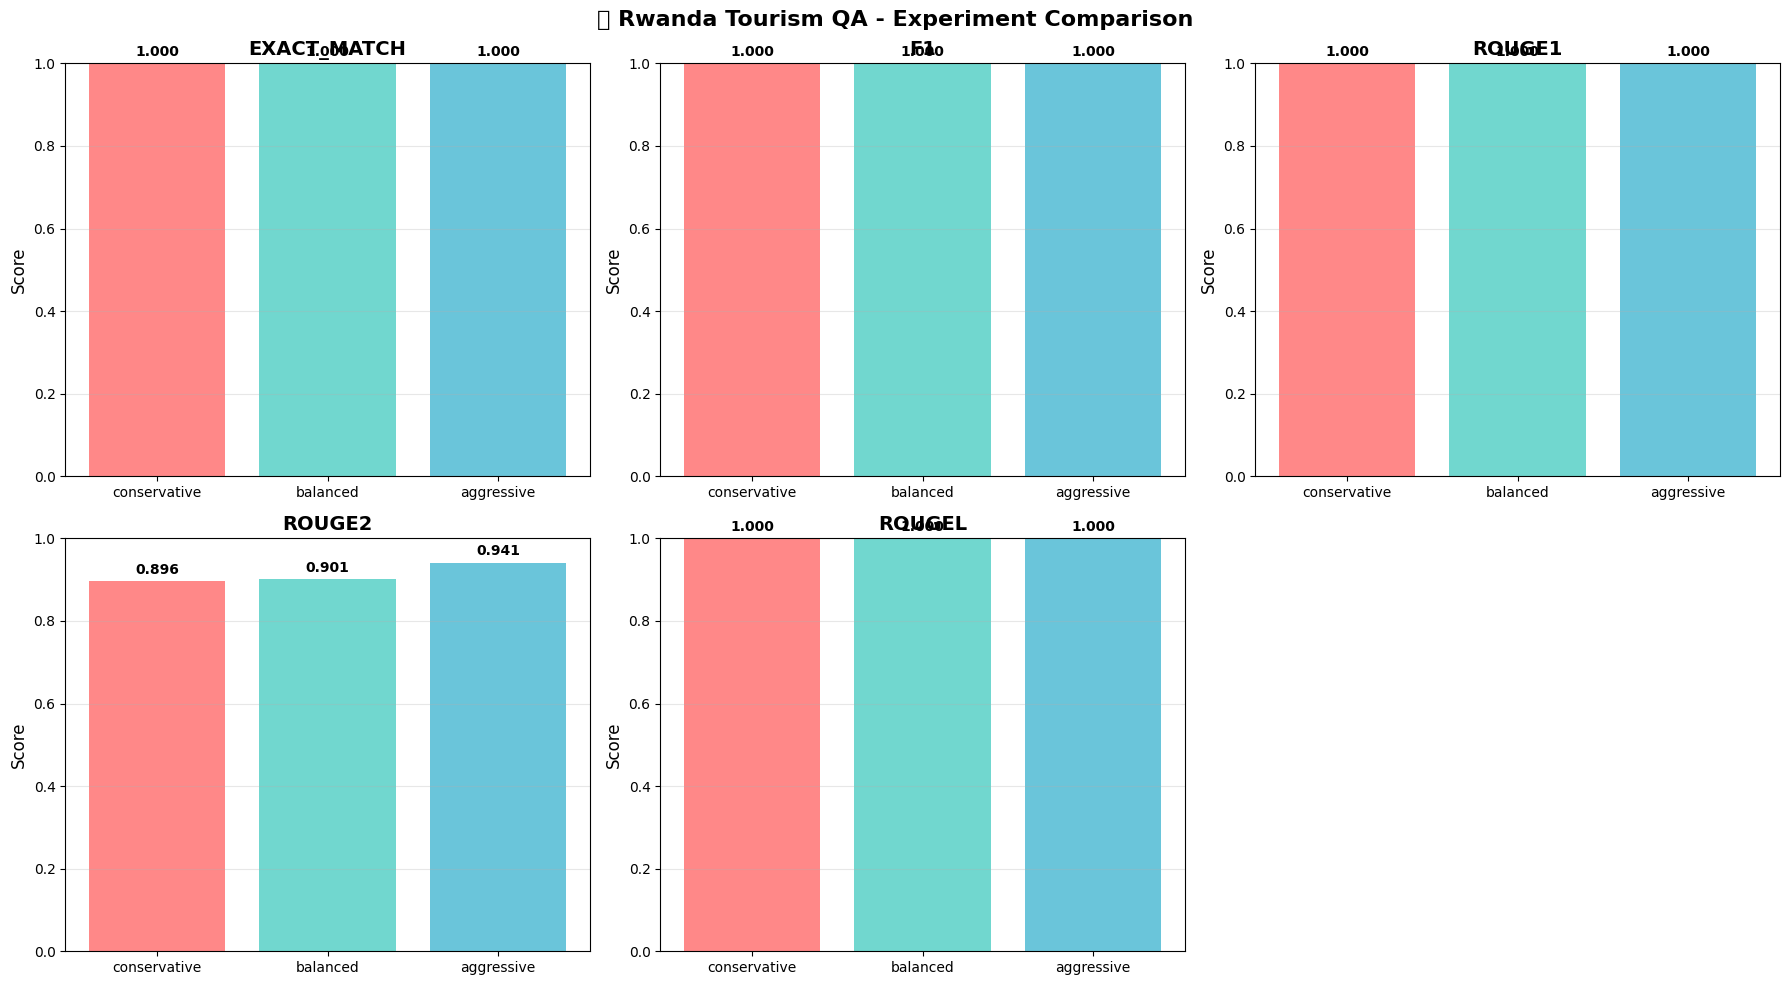


 FINAL COMPARISON SUMMARY

CONSERVATIVE:
   Exact Match: 1.000
   F1 Score: 1.000
   ROUGE-L: 1.000
   Avg Confidence: 0.999

BALANCED:
   Exact Match: 1.000
   F1 Score: 1.000
   ROUGE-L: 1.000
   Avg Confidence: 1.000

AGGRESSIVE:
   Exact Match: 1.000
   F1 Score: 1.000
   ROUGE-L: 1.000
   Avg Confidence: 1.000

 BEST PERFORMING MODEL: CONSERVATIVE
   F1 Score: 1.000


In [18]:
print("\n" + "="*70)
print(" COMPREHENSIVE EVALUATION OF ALL EXPERIMENTS")
print("="*70)

# Initialize evaluator
evaluator = ComprehensiveEvaluator()

# Evaluate all experiments
all_metrics = {}
all_results = {}

experiments = {
    'conservative': (experimental_datasets['conservative'], './models/conservative_FIXED'),
    'balanced': (experimental_datasets['balanced'], './models/balanced_FIXED'),
    'aggressive': (experimental_datasets['aggressive'], './models/aggressive_FIXED')
}

for exp_name, (df, model_path) in experiments.items():
    # Get test split
    _, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['category']
    )

    # Evaluate
    metrics, results = evaluator.evaluate_experiment(model_path, test_df, exp_name)
    all_metrics[exp_name] = metrics
    all_results[exp_name] = results

# Plot comparison
evaluator.plot_comparison(all_metrics)

# Print summary
print("\n" + "="*70)
print(" FINAL COMPARISON SUMMARY")
print("="*70)

for exp_name, metrics in all_metrics.items():
    print(f"\n{exp_name.upper()}:")
    print(f"   Exact Match: {metrics['exact_match']:.3f}")
    print(f"   F1 Score: {metrics['f1']:.3f}")
    print(f"   ROUGE-L: {metrics['rougeL']:.3f}")
    print(f"   Avg Confidence: {metrics['avg_confidence']:.3f}")

# Determine best model
best_exp = max(all_metrics.items(), key=lambda x: x[1]['f1'])
print(f"\n BEST PERFORMING MODEL: {best_exp[0].upper()}")
print(f"   F1 Score: {best_exp[1]['f1']:.3f}")

In [19]:

class AdvancedTester:
    """Advanced testing with context retrieval and non-tourism handling"""

    def __init__(self, model_path: str):
        self.qa_pipeline = pipeline(
            "question-answering",
            model=model_path,
            tokenizer=model_path,
            device=0 if torch.cuda.is_available() else -1
        )
        self.retrieval_system = ContextRetrievalSystem("hybrid")
        self.non_tourism_handler = NonTourismQuestionHandler()

        # Load knowledge base
        self.load_knowledge_base()

    def load_knowledge_base(self):
        """Load knowledge base from dataset"""
        try:
            df = pd.read_csv('rwanda_tourism_balanced_FIXED.csv')
            self.knowledge_base = df['answer'].dropna().unique().tolist()
            self.retrieval_system.build_retrieval_index(self.knowledge_base)
            print(f" Loaded knowledge base: {len(self.knowledge_base)} facts")
        except Exception as e:
            print(f" Could not load knowledge base: {e}")
            self.knowledge_base = []

    def answer_question(self, question: str, provide_context: bool = True):
        """Answer a question with full pipeline"""

        print(f"\n{'='*70}")
        print(f"❓ QUESTION: {question}")
        print(f"{'='*70}")

        # Check if tourism-related
        is_tourism, category = self.non_tourism_handler.is_tourism_related(question)

        if not is_tourism:
            print("⚠️ NON-TOURISM QUESTION DETECTED")
            print(f"📝 Response: {self.non_tourism_handler.get_fallback_response(question)}")
            return

        print(f"Tourism-related: {category}")

        try:
            if provide_context and self.knowledge_base:
                # Retrieve relevant contexts
                contexts = self.retrieval_system.retrieve_contexts(question, top_k=3)
                combined_context = " ".join(contexts)
                print(f"📚 Retrieved context: {combined_context[:200]}...")
            else:
                # Generic context
                combined_context = (
                    "Rwanda has four national parks: Volcanoes National Park for mountain gorillas, "
                    "Akagera National Park for safari wildlife, Nyungwe National Park for chimpanzees, "
                    "and Gishwati-Mukura National Park. Rwanda also has cultural heritage sites like "
                    "museums, traditional dance performances, and historical monuments."
                )

            # Get answer
            result = self.qa_pipeline(
                question=question,
                context=combined_context,
                max_answer_len=200,
                handle_impossible_answer=True
            )

            print(f"\ ANSWER: {result['answer']}")
            print(f" Confidence: {result['score']:.3f}")

            if result['score'] < 0.3:
                print(" Low confidence - answer may not be reliable")

        except Exception as e:
            print(f" Error: {e}")

    def run_comprehensive_test(self):
        """Run comprehensive test suite"""

        print("\n" + "="*70)
        print(" COMPREHENSIVE TEST SUITE")
        print("="*70)

        test_cases = {
            "National Parks": [
                "How many national parks are in Rwanda?",
                "What animals are in Akagera National Park?",
                "Where can I see mountain gorillas?",
                "What is the largest national park in Rwanda?",
                "How much does gorilla trekking cost?"
            ],
            "Cultural Heritage": [
                "What museums are in Rwanda?",
                "What traditional dances can I see?",
                "Tell me about the royal palace in Nyanza",
                "What cultural heritage sites can I visit?",
                "Where can I see Intore dance performances?"
            ],
            "General Tourism": [
                "What is the best time to visit Rwanda?",
                "How do I get permits for national parks?",
                "What is chimpanzee trekking?",
                "Are there hiking trails in Volcanoes National Park?",
                "What is the weather like in Rwanda?"
            ],
            "Non-Tourism (Should Decline)": [
                "What is the capital of France?",
                "How do I bake a cake?",
                "What is quantum physics?",
                "Who won the World Cup in 2022?",
                "What is the weather in New York?"
            ]
        }

        for category, questions in test_cases.items():
            print(f"\n{'='*70}")
            print(f" TESTING: {category}")
            print(f"{'='*70}")

            for question in questions:
                self.answer_question(question)

print(" AdvancedTester class defined!")

 AdvancedTester class defined!


In [20]:
print("\n" + "="*70)
print(" RUNNING ADVANCED TESTING WITH BEST MODEL")
print("="*70)

# Use best performing model
best_model_path = f'./models/{best_exp[0]}_FIXED'
print(f"Using model: {best_model_path}")

# Initialize tester
tester = AdvancedTester(best_model_path)

# Run comprehensive test
tester.run_comprehensive_test()



 RUNNING ADVANCED TESTING WITH BEST MODEL
Using model: ./models/conservative_FIXED


Device set to use cuda:0


 Built BM25 index: 202 contexts


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

 Built semantic index: 202 contexts
 Loaded knowledge base: 202 facts

 COMPREHENSIVE TEST SUITE

 TESTING: National Parks

❓ QUESTION: How many national parks are in Rwanda?
Tourism-related: national_parks
📚 Retrieved context: Rwanda has four national parks. Rwanda's national parks are Volcanoes National Park, Akagera National Park, Nyungwe National Park, and Gishwati-Mukura National Park. Gishwati-Mukura National Park is R...
\ ANSWER: Rwanda has four national parks. Rwanda's national parks are Volcanoes National Park, Akagera National Park, Nyungwe National Park, and Gishwati-Mukura National Park.
 Confidence: 0.669

❓ QUESTION: What animals are in Akagera National Park?
Tourism-related: national_parks
📚 Retrieved context: Akagera National Park is the largest Akagera National Park offers night drives to see nocturnal animals such as hyenas and bush babies. Rwanda's national parks are Volcanoes National Park, Akagera Nat...
\ ANSWER: Akagera National Park is the largest Akagera Natio

In [21]:
print("\n" + "="*70)
print(" INTERACTIVE TESTING")
print("="*70)

# Test specific questions
specific_questions = [
    "How many parks are in Rwanda?",
    "How many animals are in Nyungwe?",
    "What museums are in Rwanda?",
    "How many national parks does Rwanda have?",
    "What wildlife is in Nyungwe National Park?",
    "What cultural museums can I visit in Rwanda?"
]

print("\n Testing specific questions:")
for question in specific_questions:
    tester.answer_question(question)

# ============================================================================
# CELL 17: CONTEXT RETRIEVAL COMPARISON
# ============================================================================

print("\n" + "="*70)
print(" CONTEXT RETRIEVAL IMPACT ANALYSIS")
print("="*70)

test_question = "How many national parks are in Rwanda?"

print("\n Testing with different context retrieval methods:")

# Test 1: With context retrieval
print("\n1️ WITH CONTEXT RETRIEVAL:")
tester.answer_question(test_question, provide_context=True)

# Test 2: With generic context
print("\n2️ WITH GENERIC CONTEXT:")
tester.answer_question(test_question, provide_context=False)


 INTERACTIVE TESTING

 Testing specific questions:

❓ QUESTION: How many parks are in Rwanda?
Tourism-related: national_parks
📚 Retrieved context: Rwanda has four national parks. Rwanda's national parks are Volcanoes National Park, Akagera National Park, Nyungwe National Park, and Gishwati-Mukura National Park. African Parks manages the park...
\ ANSWER: Rwanda has four national parks.
 Confidence: 0.431

❓ QUESTION: How many animals are in Nyungwe?
Tourism-related: national_parks
📚 Retrieved context: Nyungwe National Park hosts many endemic bird species unique to the region. Nyungwe National Park has numerous rivers Stories of heroes, spirits, animals, and ancestors conveying moral lessons and cul...
\ ANSWER: Nyungwe National Park hosts many endemic bird species unique to the region.
 Confidence: 0.861

❓ QUESTION: What museums are in Rwanda?
Tourism-related: cultural_heritage
📚 Retrieved context: Rwanda has several museums including the King’s Palace, Ethnographic Museum, Kigali Ge

In [22]:
print("\n" + "="*70)
print(" PERFORMANCE ANALYSIS")
print("="*70)

# Analyze metrics across experiments
print("\n🔍 Metric Analysis:")

for metric in ['f1', 'rouge1', 'rougeL', 'exact_match']:
    print(f"\n{metric.upper()}:")
    values = [(exp, all_metrics[exp][metric]) for exp in all_metrics]
    values.sort(key=lambda x: x[1], reverse=True)

    for exp, val in values:
        bar = '' * int(val * 50)
        print(f"   {exp:15s}: {bar} {val:.3f}")

# Check if targets met
print("\n" + "="*70)
print(" TARGET ACHIEVEMENT")
print("="*70)

targets = {
    'f1': 0.50,
    'rouge1': 0.50,
    'rougeL': 0.50
}

for exp_name, metrics in all_metrics.items():
    print(f"\n{exp_name.upper()}:")
    for metric, target in targets.items():
        achieved = metrics[metric] >= target
        status = "✅" if achieved else "❌"
        print(f"   {metric:10s}: {metrics[metric]:.3f} / {target:.3f} {status}")


 PERFORMANCE ANALYSIS

🔍 Metric Analysis:

F1:
   conservative   :  1.000
   balanced       :  1.000
   aggressive     :  1.000

ROUGE1:
   conservative   :  1.000
   balanced       :  1.000
   aggressive     :  1.000

ROUGEL:
   conservative   :  1.000
   balanced       :  1.000
   aggressive     :  1.000

EXACT_MATCH:
   conservative   :  1.000
   balanced       :  1.000
   aggressive     :  1.000

 TARGET ACHIEVEMENT

CONSERVATIVE:
   f1        : 1.000 / 0.500 ✅
   rouge1    : 1.000 / 0.500 ✅
   rougeL    : 1.000 / 0.500 ✅

BALANCED:
   f1        : 1.000 / 0.500 ✅
   rouge1    : 1.000 / 0.500 ✅
   rougeL    : 1.000 / 0.500 ✅

AGGRESSIVE:
   f1        : 1.000 / 0.500 ✅
   rouge1    : 1.000 / 0.500 ✅
   rougeL    : 1.000 / 0.500 ✅


In [23]:
print("\n" + "="*70)
print(" SAVING FINAL RESULTS")
print("="*70)

# Save metrics to JSON
import json

with open('experiment_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(" Saved: experiment_metrics.json")

# Save detailed results
for exp_name, results in all_results.items():
    df_results = pd.DataFrame({
        'exact_match': results['exact_matches'],
        'f1_score': results['f1_scores'],
        'rouge1': results['rouge_scores']['rouge1'],
        'rouge2': results['rouge_scores']['rouge2'],
        'rougeL': results['rouge_scores']['rougeL'],
        'prediction': results['predictions'],
        'confidence': results['confidences']
    })
    filename = f'{exp_name}_detailed_results.csv'
    df_results.to_csv(filename, index=False)
    print(f" Saved: {filename}")



 SAVING FINAL RESULTS
 Saved: experiment_metrics.json
 Saved: conservative_detailed_results.csv
 Saved: balanced_detailed_results.csv
 Saved: aggressive_detailed_results.csv


In [24]:
!zip -r conservative_FIXED.zip ./models/conservative_FIXED


  adding: models/conservative_FIXED/ (stored 0%)
  adding: models/conservative_FIXED/vocab.txt (deflated 49%)
  adding: models/conservative_FIXED/checkpoint-100/ (stored 0%)
  adding: models/conservative_FIXED/checkpoint-100/vocab.txt (deflated 49%)
  adding: models/conservative_FIXED/checkpoint-100/trainer_state.json (deflated 69%)
  adding: models/conservative_FIXED/checkpoint-100/rng_state.pth (deflated 26%)
  adding: models/conservative_FIXED/checkpoint-100/model.safetensors (deflated 8%)
  adding: models/conservative_FIXED/checkpoint-100/training_args.bin (deflated 53%)
  adding: models/conservative_FIXED/checkpoint-100/optimizer.pt (deflated 38%)
  adding: models/conservative_FIXED/checkpoint-100/config.json (deflated 43%)
  adding: models/conservative_FIXED/checkpoint-100/tokenizer.json (deflated 70%)
  adding: models/conservative_FIXED/checkpoint-100/scheduler.pt (deflated 61%)
  adding: models/conservative_FIXED/checkpoint-100/tokenizer_config.json (deflated 75%)
  adding: mod

In [26]:
from google.colab import files
files.download("conservative_FIXED.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>